# Передача стиля

In [ ]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def load_image(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

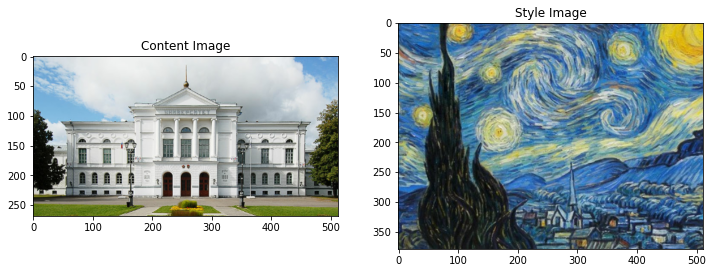

In [ ]:
content_path = '/content/drive/MyDrive/img_style/img_10.jpg'
style_path = '/content/drive/MyDrive/img_style/img_7.jpg'

content_path = tf.keras.utils.get_file('tsu.jpg', 'https://www.tsu.ru/upload/medialibrary/6c5/tsu.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('zvezdnoe_nebo.jpeg','https://www.hse.ru/data/2017/05/17/1171369516/zvezdnoe_nebo.jpeg')

content_image = load_image(content_path)
style_image = load_image(style_path)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(content_image[0])
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(style_image[0])
plt.title('Style Image')
plt.show()

In [ ]:
# Получается из просмотренной теории нам нужен один слой для контента.
# Во первых этот слой должен быть глубоким так как на глубоких слоях формируются (абстрактные) фичи
# т.е по русски чем глубже слой тем более крупные и понятные признаки
# например глаза, колеса, более большие предметы

content_layers = ['block5_conv2'] 

# Так же исходя из просмотренной теории для передачи стиля нам нужны признаки с многих слоев,
# так как нам нужны и мелкие детали стиля и так же его более понятные признаки

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model


In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [ ]:
# Пытаемся переписать класс!
class StyleContentModel(tf.keras.models.Model):
  
  def __init__(self, style_layers, content_layers, style_alfa=1e-2, content_betta=1e4, optimizer=None):
    super(StyleContentModel, self).__init__()

    self.style_alfa = style_alfa
    self.content_betta = content_betta
    

    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
    
    if optimizer == None:
      self.opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    else:
      self.opt = optimizer

  def gram_matrix(self, input_tensor):
    """
    Метод для подсчета матирицы Грамма.
    channels это количество map фичей т.е. это такой же параметр в сверточном слое типа количество фильтров в сверточном слое
    далее так как у нас трехмерный тензор нам нужно превратить его в двумерный, получается что мы берем все строки например для
    первой карты фичей и как бы вытягиваем ее в 1 мерный тензор и таких тензоров у нас столько сколько карт фичей
    В итоге получается двумерная матрица где одним индексом является количество фичей а другим индексом вытянутое изобраджение карты
    фичей. Далее мы транспонируем эту матрицу и вычисляем векторное произведение начальной матрицы и транспонированной.
    Получается как бы матрица кореляции признаков т.е если все признаки есть в пикселе то значение будект максимальным
    Еще матрица получается размерность количество карт фичей на количество карт фичей. Делим на количество как бы пикселей в карте фичей что бы
    значения в получившейся матрице не зависили от количество пикселей

    :param input_tensor: 
    :return: 
    """
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

  def get_content_loss(self, content, input_img):
    """
    Исходя из теории потери контента будут рассчитываться как разность между изображениями
    или фичами контента и входной картинки для определенного слоя
    т.е. для тех выходных слоев которые мы добавили в модель VGG

    :param content:
    :param input_img:
    :return:
    """
    return tf.reduce_mean(tf.square(content - input_img))
    

  def get_style_loss(self, gram_style, gram_style_image):
    """
    Теперь до конца можно реализвать функцию потерь по стилю
    На вход подается input_style это карта стилей формируемого изображения
    и gram_style_image это матрица грамма для изображения стиля
    ее мы можем посчитать один раз потому что картинка со стилем у нас не меняется
    
    :param gram_style: 
    :param gram_style_image: 
    :return: 
    """
    return tf.reduce_mean(tf.square(gram_style - gram_style_image))

  def style_content_loss(self):
  
    style_outputs = self.outputs['style']
    content_outputs = self.outputs['content']

    style_loss = 0
    for name in style_outputs.keys():
      style_loss += self.get_style_loss(style_outputs[name], style_targets[name])
    style_loss *= self.style_alfa / num_style_layers

    content_loss = 0
    for name in content_outputs.keys():
      content_loss += self.get_content_loss(content_outputs[name], content_targets[name])
    content_loss *= self.content_betta / num_content_layers


    loss = style_loss + content_loss
    return loss

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [self.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    self.outputs = {'content':content_dict, 'style':style_dict}
    return self.outputs


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor.call(style_image)['style']
content_targets = extractor.call(content_image)['content']

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_weight=30

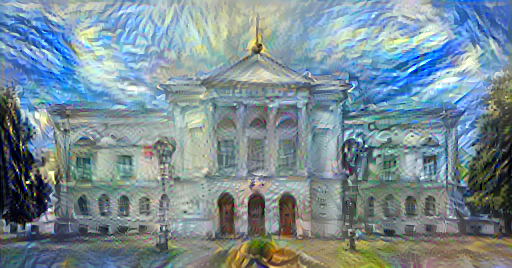

Train step: 999
loss: tf.Tensor([5798241.], shape=(1,), dtype=float32)
Total time: 648.2


In [ ]:
image = tf.Variable(content_image)

import time
start = time.time()

steps = 1000
for step in range(steps):
  with tf.GradientTape() as tape:
    outputs = extractor.call(image)
    loss = extractor.style_content_loss()
    loss += total_variation_weight*tf.image.total_variation(image)
    

  grad = tape.gradient(loss, image)
  extractor.opt.apply_gradients([(grad, image)])
  clipped = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
  image.assign(clipped)


  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  print('loss:', loss)
  time.sleep(0.5)
end = time.time()
print("Total time: {:.1f}".format(end-start))
